In [1]:
import socket
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd

from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu
import s2widthcut_utility as wcu
import math
from datetime import datetime, timedelta
import cutax
from straxen.get_corrections import get_correction_from_cmt
from cutax.cuts import *

%load_ext autoreload
%autoreload 2
#import importlib
#importlib.reload(cutax)

In [2]:
straxen.print_versions()

,module,version,path,git
0,python,3.8.13,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.3/b...,None
1,strax,1.2.3,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.3/l...,None
2,straxen,1.7.1,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.3/l...,None
3,cutax,1.12.0,/dali/lgrandi/xenonnt/software/cutax/v1.12.0/c...,None


In [3]:
#st = cutax.xenonnt_v5(cuts_for=['science_run_0.krypton_selections', 'commissioning.commissioning_cuts'])
st = cutax.contexts.xenonnt_v8(cut_list=[cutax.cut_lists.basic.BasicCuts,cutax.cut_lists.s2width_test.S2Width])
#st = cutax.xenonnt_online()
#st.register(FiducialVolumeCylinder)
FiducialVolume = st.get_single_plugin('030000', 'cut_fiducial_volume')
NearWires = st.get_single_plugin('030000', 'cut_near_wires')

In [5]:
#evRn0 = pd.read_hdf('/dali/lgrandi/dandrea/data/20220603_sr0_rn220_v8.h5', key='df')
#evRn = evRn0[wcu.all_cuts(evRn0,analysis=1)]
#evRn.to_pickle('/dali/lgrandi/dandrea/data/20220603_sr0_rn220_v8_cuts.pkl')
evRn = pd.read_pickle('/dali/lgrandi/dandrea/data/20220603_sr0_rn220_v8_cuts.pkl')

In [6]:
#evAr0 = pd.read_hdf('/dali/lgrandi/dandrea/data/20220603_sr0_ar37_v8.h5', key='df')
#evAr = evAr0[wcu.all_cuts(evAr0,analysis=1)]
#evAr.to_pickle('/dali/lgrandi/dandrea/data/20220603_sr0_ar37_v8_cuts.pkl')
evAr = pd.read_pickle('/dali/lgrandi/dandrea/data/20220603_sr0_ar37_v8_cuts.pkl')

In [7]:
#evAB0 = pd.read_hdf('/dali/lgrandi/dandrea/data/20220603_sr0_ambe_v8.h5', key='df')
#evAB = evAB0[wcu.all_cuts(evAB0,analysis=1)]
#evAB.to_pickle('/dali/lgrandi/dandrea/data/20220603_sr0_ambe_v8_cuts.pkl')
evAB = pd.read_pickle('/dali/lgrandi/dandrea/data/20220603_sr0_ambe_v8_cuts.pkl')

In [8]:
#ev_sim = np.load('/dali/lgrandi/shenyangshi/s2_width_wfsim_0615.npy', allow_pickle=True)
#ev_sim = np.load('/dali/lgrandi/shenyangshi/bdt_acceptance_0620.npy', allow_pickle=True).item()
ev_sim = pd.read_hdf('/dali/lgrandi/xudc/wfsim_cat_0621.h5', key='wfsim_df')
#ev_sim = ev_sim['wfsim']
ev_sim = ev_sim[FiducialVolume.cut_by(ev_sim)]

In [9]:
vd = get_correction_from_cmt('024075',('electron_drift_velocity', 'ONLINE', True))
gd = get_correction_from_cmt('024075',('electron_drift_time_gate', 'ONLINE', True))
dc = get_correction_from_cmt('024075',('electron_diffusion_cte', 'ONLINE', True))
par = (dc,vd,gd)
print(par)

(4.566e-08, 6.77e-05, 2700.0)


# WFsim Acceptance

In [14]:
# FAR FROM WIRES 1-99%
cut_far = (( 0.75785949 , 3.18263529 , 1.26349891 ),
          ( 4.74467848 , 1.34106577 , 1.99650474 , 1.02559667 ))
# NEAR WIRES 5-99%
cut_near = (( 0.7742574 , 2.92714807 , 1.22338626 ),
           ( 4.74467848 , 1.34106577 , 1.99650474 , 1.02559667 ))

Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634786 0.19632401]
param_parabola_high: [ 0.12086553 -1.2295208   4.37596581]
Cut: total 555953, survived 535929 -> 96.40%


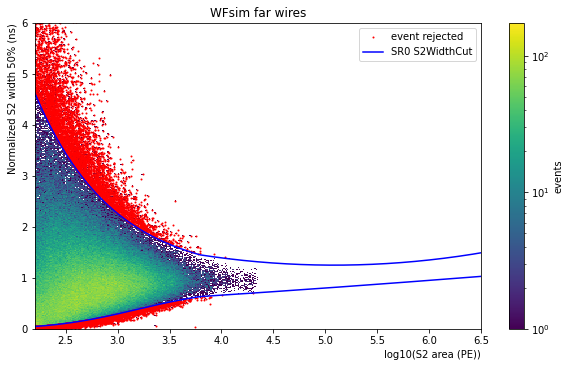

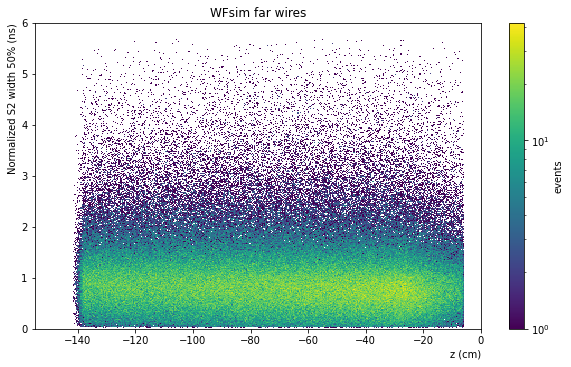

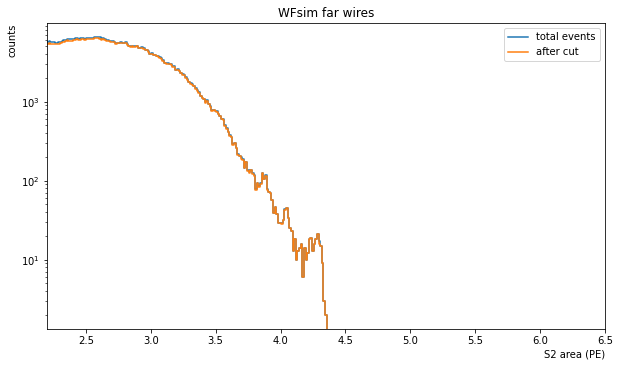

In [15]:
mask_near_wires = NearWires.cut_by(ev_sim)
"""
# get cut mask for WFsim near wires for WIMPs 1-99%
cut_mask_sim_near = wcu.S2WidthCut(ev_sim[mask_near_wires], title='WFsim near wires',
                                   mod_par=par, bins=400,
                                   wrange=(0,6), arange = (2.2,6.5), plot = 0,
                                   perc_plot=0,
                                   ext_par=cut_near, near_wires=1, wire_model=1 )
cut_mask_sim_near = cut_mask_sim_near[1]
"""
# get cut mask for WFsim far from wires for WIMPs 1-99%
cut_mask_sim_far = wcu.S2WidthCut(ev_sim[~mask_near_wires], title='WFsim far wires',
                                  mod_par=par, bins=400,
                                  wrange=(0,6), arange = (2.2,6.5), plot = 1,
                                  perc_plot=0,
                                  ext_par=cut_far)
cut_mask_sim_far = cut_mask_sim_far[1]
#cut_mask_sim_near[~mask_near_wires] = True
#cut_mask_sim_far[mask_near_wires] = True 
#cut_mask_sim = cut_mask_sim_near & cut_mask_sim_far

/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:829: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


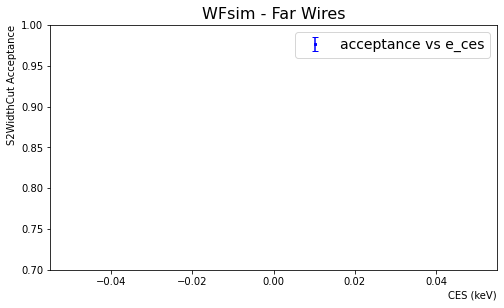

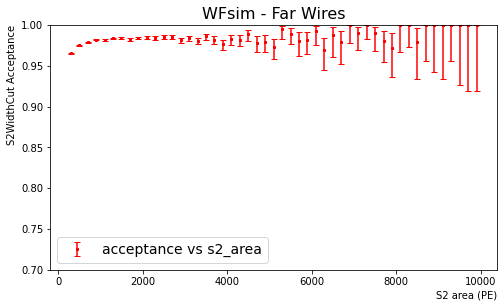

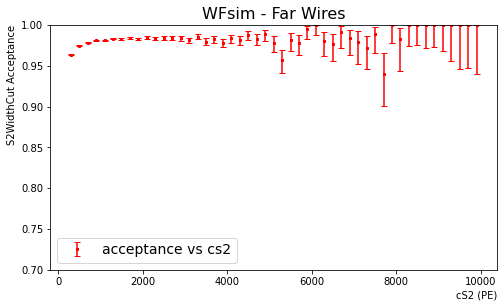

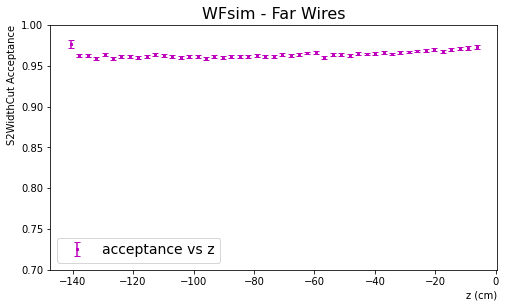

In [16]:
#wcu.plot_r2z_xy(ev_sim, 'WFsim - Far Wires')
accFarSim = wcu.get_acceptance(ev_sim, cut_mask_sim_far,sim=1,
                               title='WFsim - Far Wires', alim=(0.7,1))

In [13]:
accFarSim.to_pickle('/dali/lgrandi/dandrea/sr0_20220603_v8_s2WidthCut_acceptance_WFsim.pkl')

# Data Acceptance - WIMPs

/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:829: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


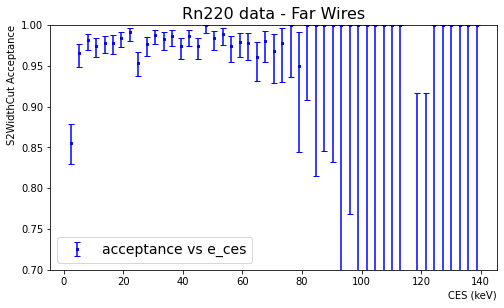

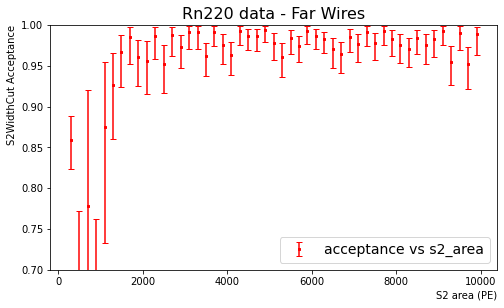

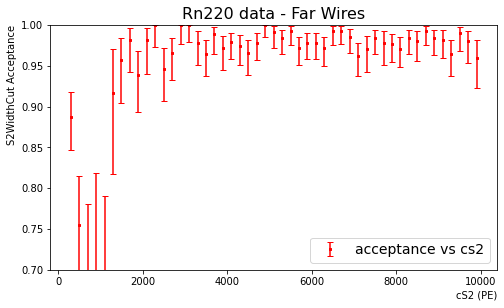

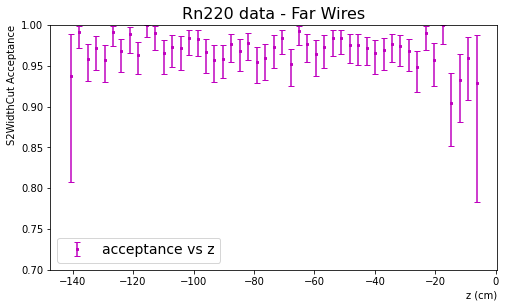

In [11]:
evFar = evRn[evRn['cut_near_wires']==0]
#wcu.plot_r2z_xy(evFar, 'AmBe data - Far Wires')
accFarRn = wcu.get_acceptance(evFar, evFar['cut_s2_width_wire_modeled_wimps'],
                              title='Rn220 data - Far Wires', alim=(0.7,1))

/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:829: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:829: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:829: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


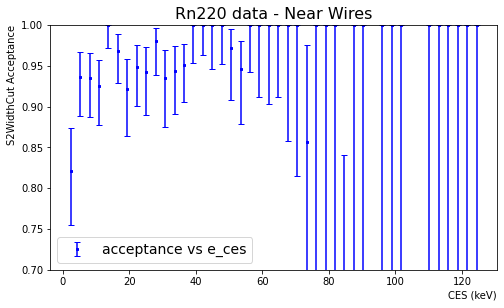

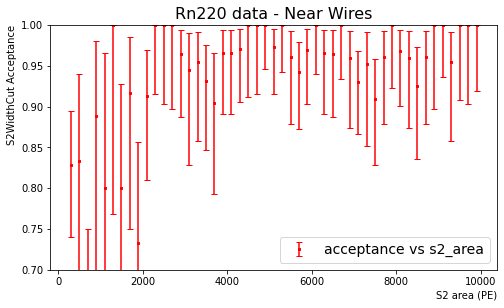

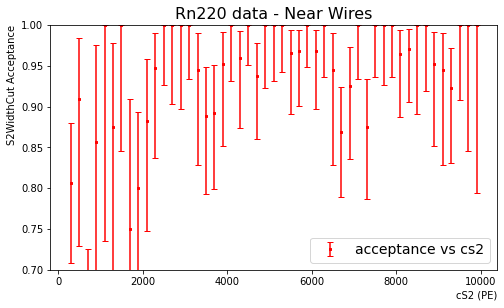

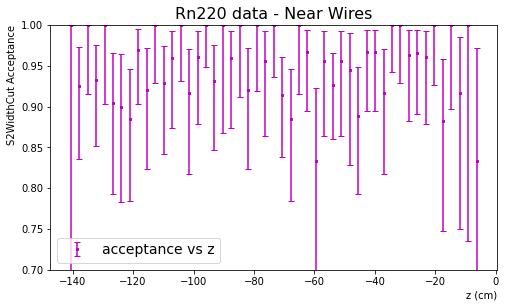

In [18]:
evNear = evRn[evRn['cut_near_wires']]
accNearRn = wcu.get_acceptance(evNear, evNear['cut_s2_width_wire_modeled_wimps'],
                              title='Rn220 data - Near Wires', alim=(0.7,1))

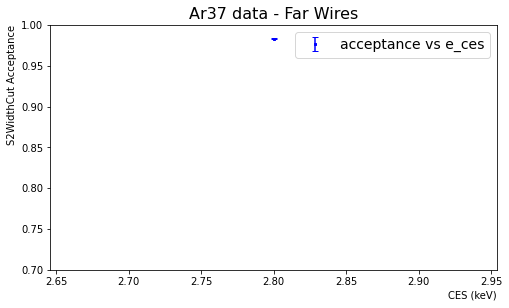

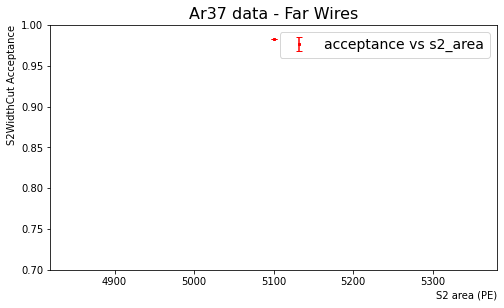

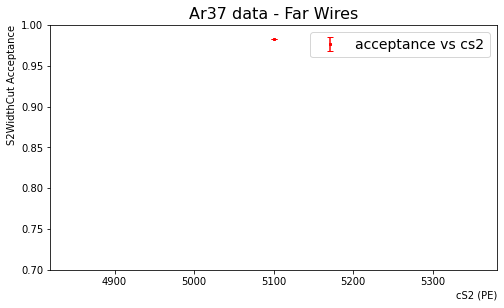

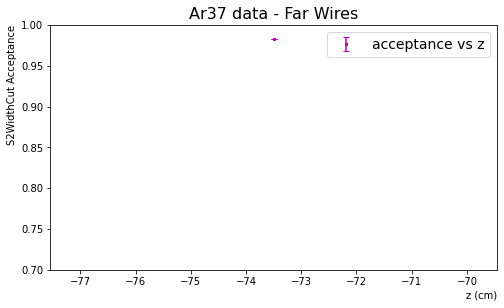

In [12]:
evFar = evAr[(evAr['cut_near_wires']==0) & (evAr['e_ces'] < 4) & (evAr['e_ces'] > 1.7)]
accFarAr = wcu.get_acceptance(evFar, evFar['cut_s2_width_wire_modeled_wimps'],
                              title='Ar37 data - Far Wires', alim=(0.7,1), Ar37=1,bins=2)

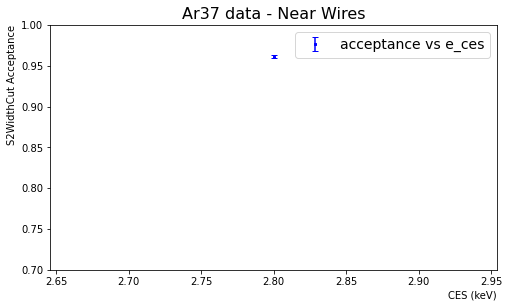

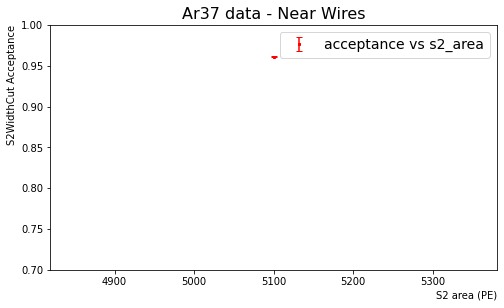

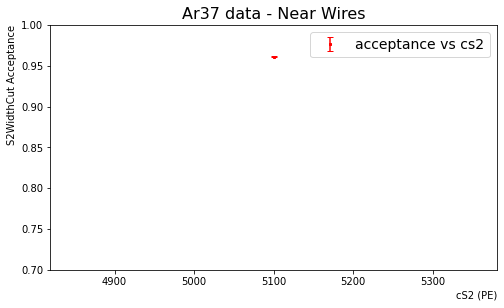

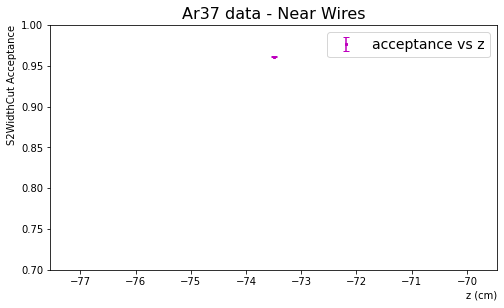

In [19]:
evNear = evAr[(evAr['cut_near_wires']) & (evAr['e_ces'] < 4) & (evAr['e_ces'] > 1.7)]
accNearAr = wcu.get_acceptance(evNear, evNear['cut_s2_width_wire_modeled_wimps'],
                              title='Ar37 data - Near Wires', alim=(0.7,1), Ar37=1,bins=2)

/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),
/home/valerioda/xenon-notes/fast_response_analysis/s2wid

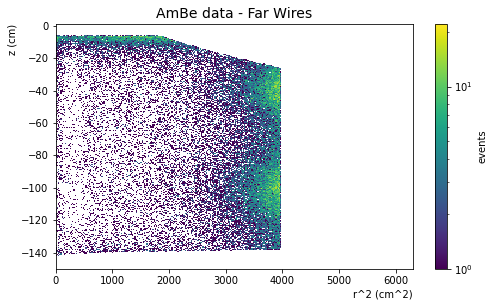

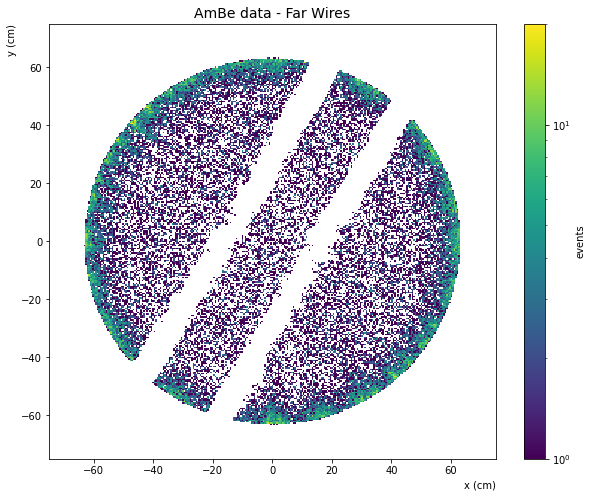

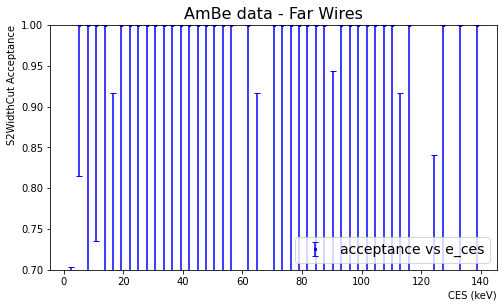

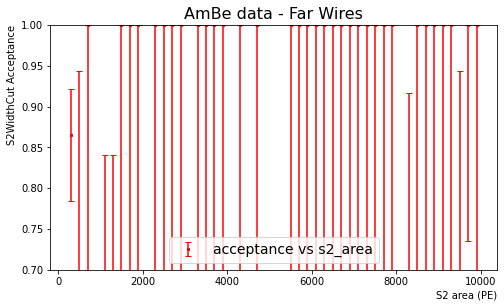

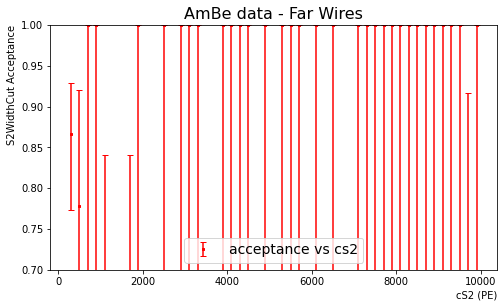

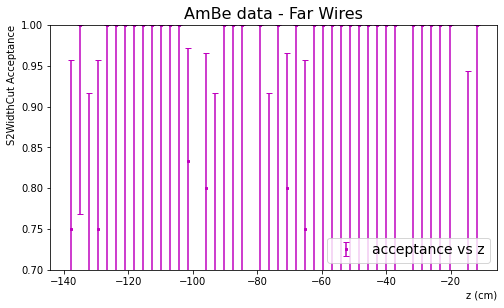

In [17]:
evFar = evAB[evAB['cut_near_wires']==0]
wcu.plot_r2z_xy(evFar, 'AmBe data - Far Wires')
accFarAB = wcu.get_acceptance(evFar, evFar['cut_s2_width_wire_modeled_wimps'],
                              title='AmBe data - Far Wires', alim=(0.7,1))

/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invali

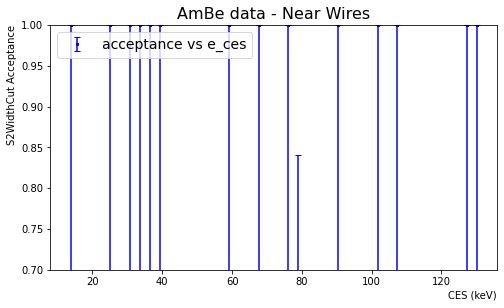

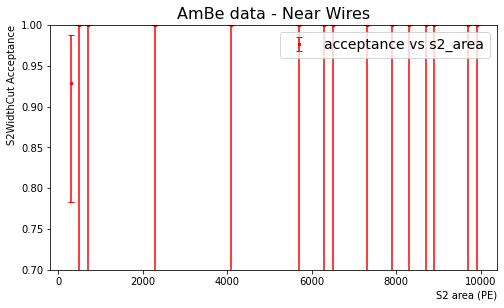

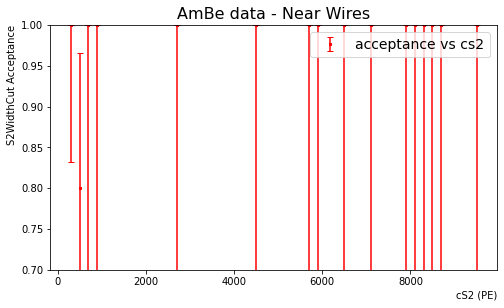

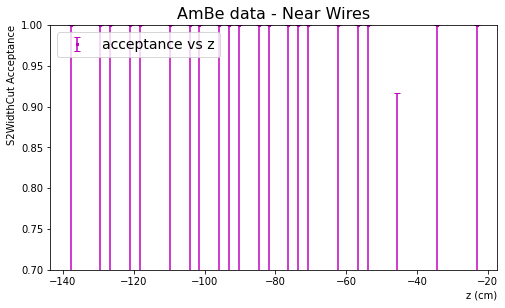

In [18]:
evNear = evAB[evAB['cut_near_wires']]
accNearAB = wcu.get_acceptance(evNear, evNear['cut_s2_width_wire_modeled_wimps'],
                              title='AmBe data - Near Wires', alim=(0.7,1))

In [19]:
evKr0 = pd.read_pickle(f'/dali/lgrandi/dandrea/data//SR0_v8_Kr83m_023398_023449_EventInfoDouble.pkl')

In [20]:
def apply_cut(events, title = 'Kr-83m', near = False, name = None, plot = False):
    #KrSelection = st.get_single_plugin('030000', 'cut_Kr_SingleS1S2')
    #mask = KrSelection.cut_by(events)
    mask = ddu.mask_KrSingleS1(events,sr0=1)
    maskFW, maskNW = wcu.mask_S2Width_vs_pos_kr(events)
    if near: ev = events[mask & maskNW]
    else: ev = events[mask & maskFW]
    cut_mask_kr = wcu.S2WidthCut(ev, title=title, mod_par=par, bins=400, name = name,
                             wrange=(0,6),arange=(2.6,4.8), plot = plot, perc_plot=0,
                             ext_par=cut_far, near_wires=near, wire_model=near,kr=1 )
    acc_kr = wcu.get_acceptance_kr(ev, cut_mask_kr[1], title=title, alim=(0.95,0.97),bins=2, plot = plot, name = name)
    return acc_kr

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634786 0.19632401]
param_parabola_high: [ 0.12086553 -1.2295208   4.37596581]
Cut: total 1276853, survived 1228471 -> 96.21%


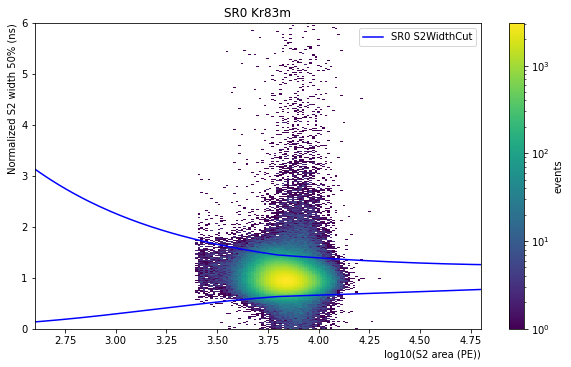

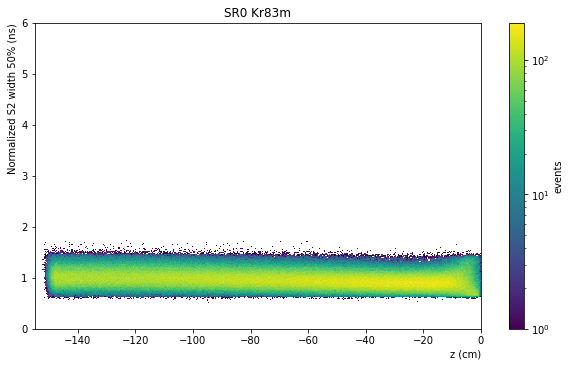

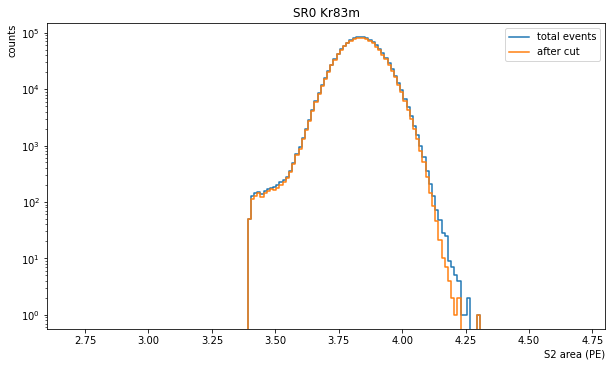

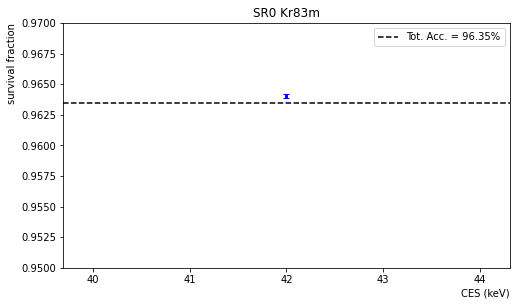

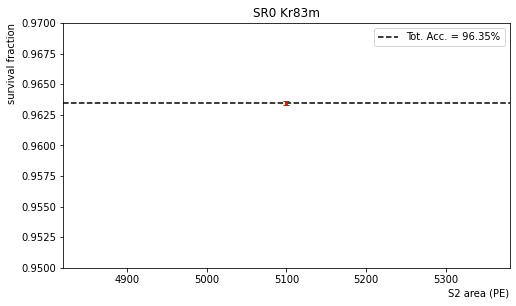

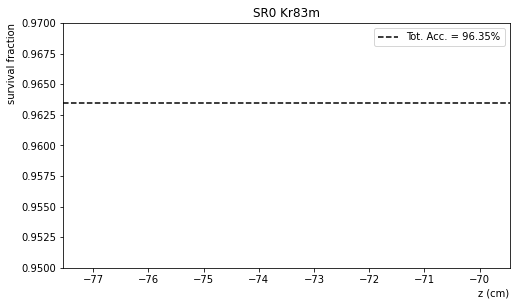

In [21]:
accFarKr = apply_cut(evKr0, title = 'SR0 Kr83m', plot = 1)

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634786 0.19632401]
param_parabola_high: [ 0.12086553 -1.2295208   4.37596581]
Cut: total 180605, survived 176877 -> 97.94%


/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: Run

Cut wire modeled: total 180605, survived 175805 -> 97.34%


/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


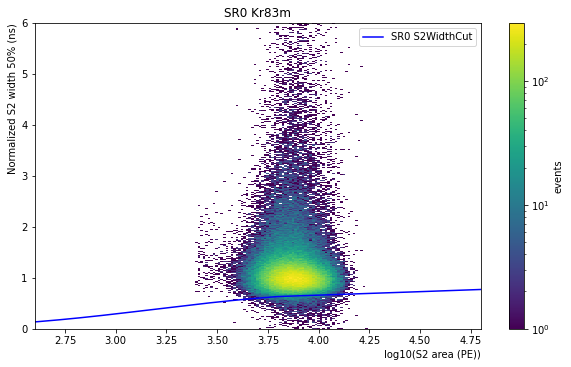

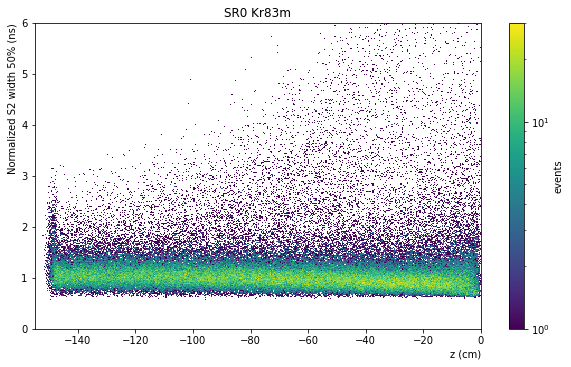

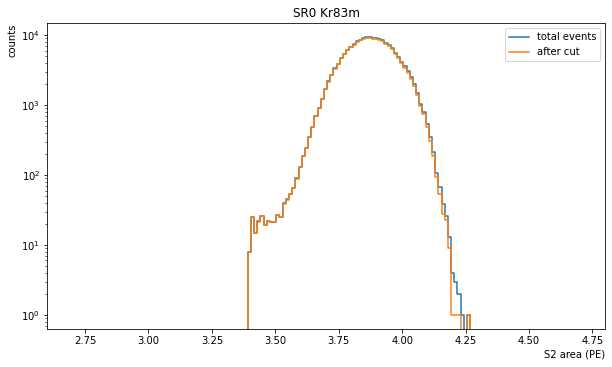

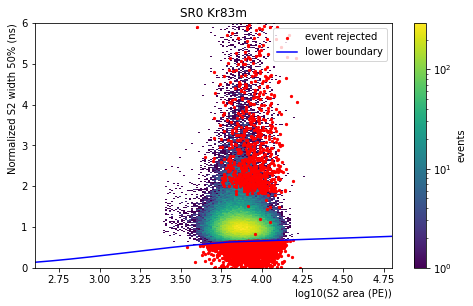

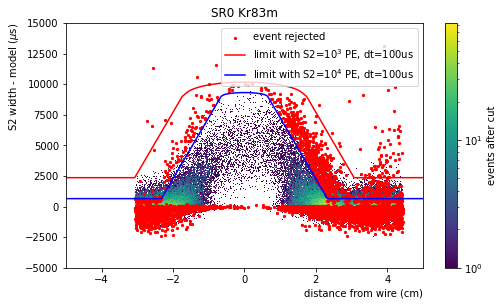

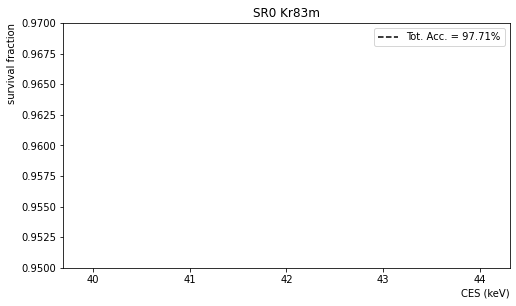

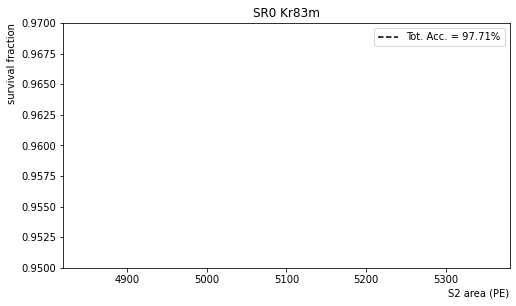

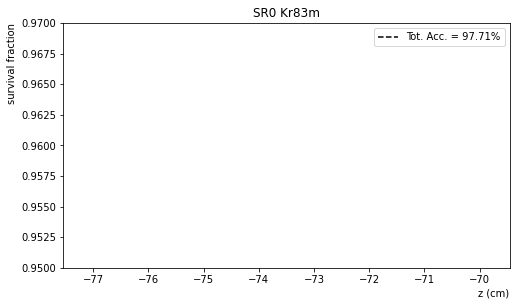

In [22]:
accNearKr = apply_cut(evKr0, title = 'SR0 Kr83m', near=1,plot = 1)

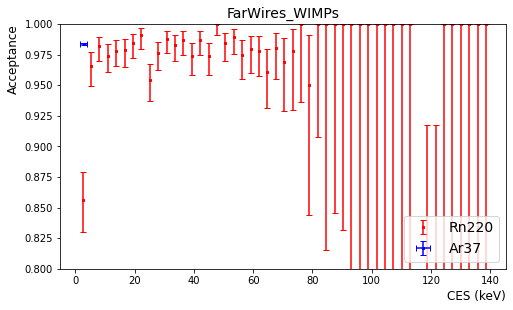

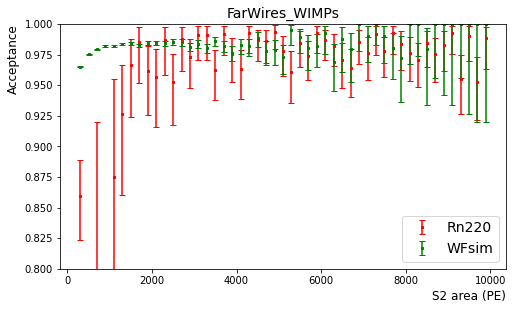

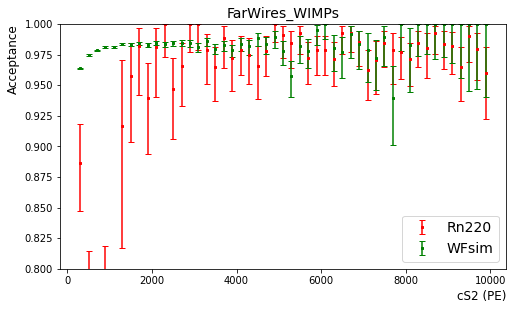

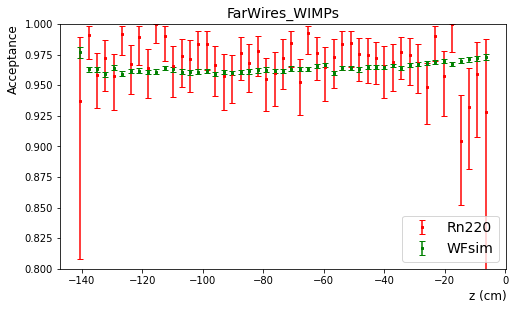

In [17]:
wcu.plot_acceptance(accFarRn, accFarSim, accFarAr, alim=(0.8,1),title='FarWires_WIMPs',info='Rn220',save=1)

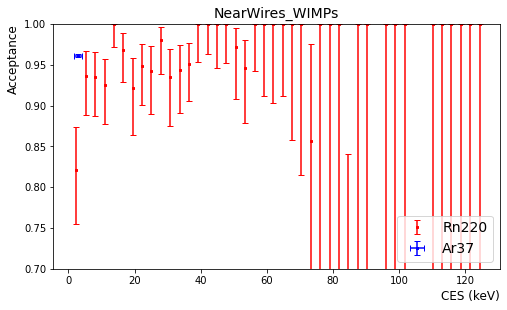

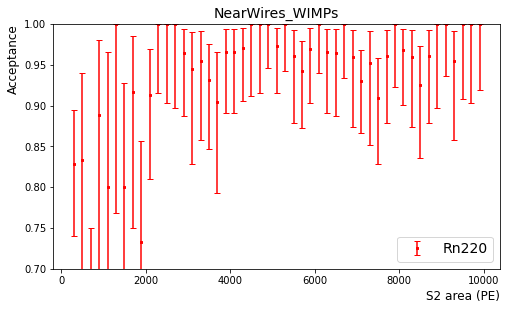

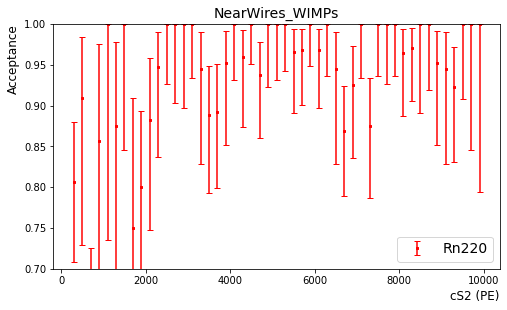

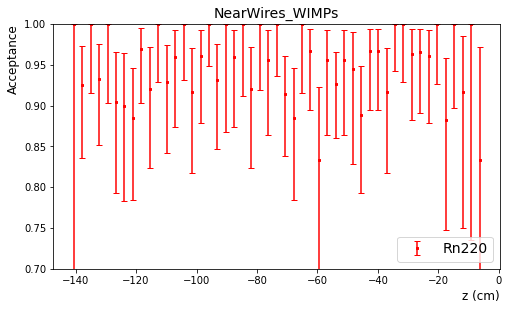

In [20]:
wcu.plot_acceptance(accNearRn, acc_ar=accNearAr, alim=(0.7,1),title='NearWires_WIMPs', info='Rn220',save=1)

/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


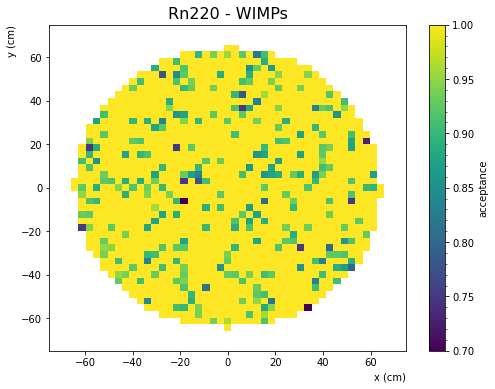

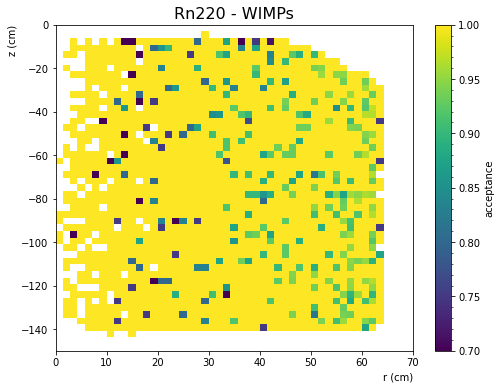

In [25]:
xy_acc=wcu.get_acceptance_2d(evRn, evRn['cut_s2_width_wire_modeled_wimps'], title='Rn220 - WIMPs', bins = 50, name='rn220_wimps_')

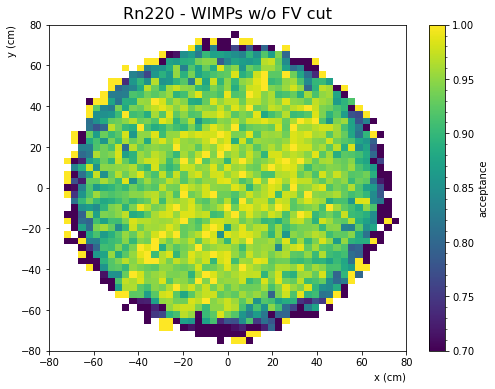

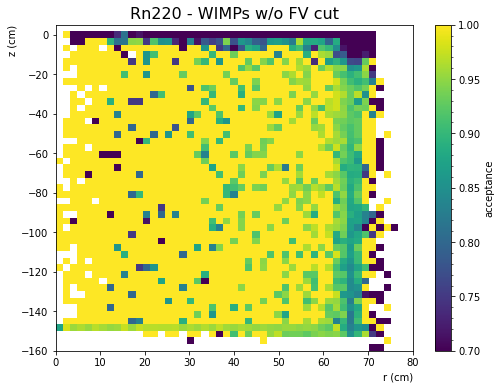

In [26]:
evRn_ = evRn0[wcu.all_cuts(evRn0,wimps=1,FV=0)]
wcu.get_acceptance_2d(evRn_, evRn_['cut_s2_width_wire_modeled_wimps'], title='Rn220 - WIMPs w/o FV cut', bins = 50,
                      xlim=80,rlim=(0,80),zlim=(-160,5),name='rn220_wimps_nofv_')

# Data Acceptance - LowER

In [27]:
evRn_l = evRn0[wcu.all_cuts(evRn0,low_er=1)]

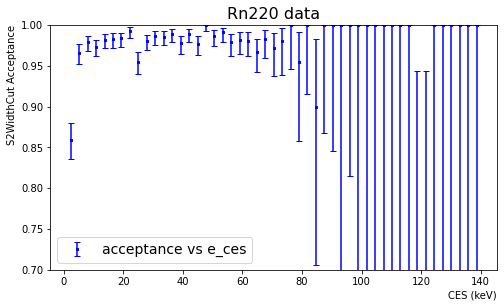

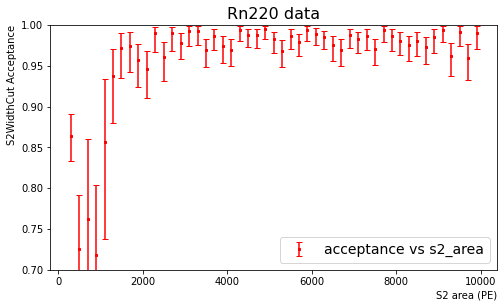

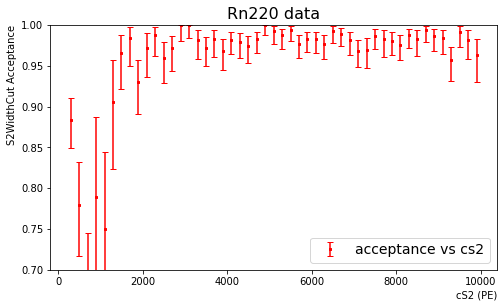

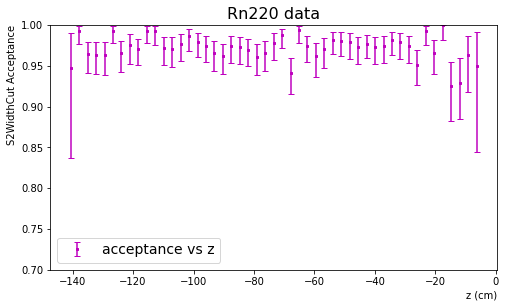

In [28]:
accRn_low_er = wcu.get_acceptance(evRn_l, evRn_l['cut_s2_width_wire_modeled_low_er'],title='Rn220 data', alim=(0.7,1))

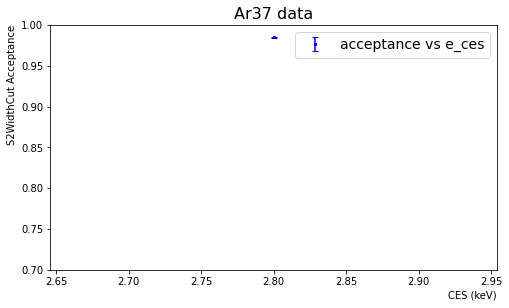

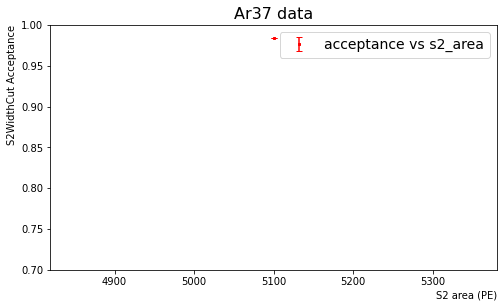

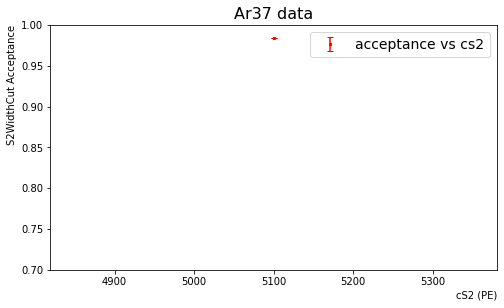

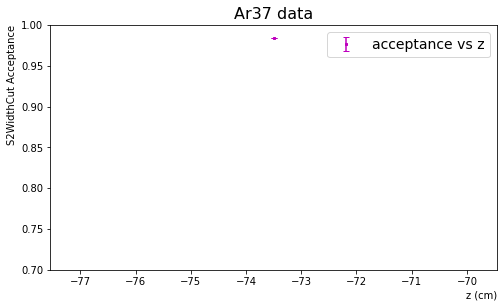

In [29]:
evAr_l = evAr0[wcu.all_cuts(evAr0,low_er=1)]
evA = evAr_l[(evAr_l['e_ces'] < 4) & (evAr_l['e_ces'] > 1.7)]
accAr_low_er = wcu.get_acceptance(evA, evA['cut_s2_width_wire_modeled_low_er'],title='Ar37 data', alim=(0.7,1), Ar37=1,bins=2)

In [30]:
# get cut mask for WFsim for LowER 1-99%
cut_mask_sim_low_er = wcu.S2WidthCut(ev_sim, title='WFsim', mod_par=par, bins=400,
                                  wrange=(0,6), arange = (2.2,6.5), plot = 0, perc_plot=0, ext_par=cut_far)
cut_mask_sim_low_er = cut_mask_sim_low_er[1]

/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:765: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


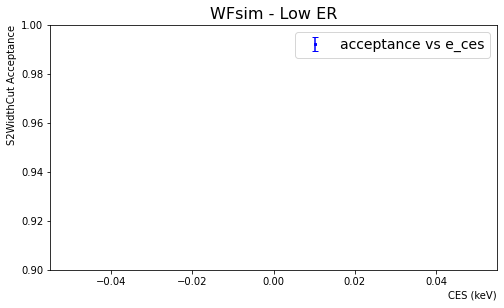

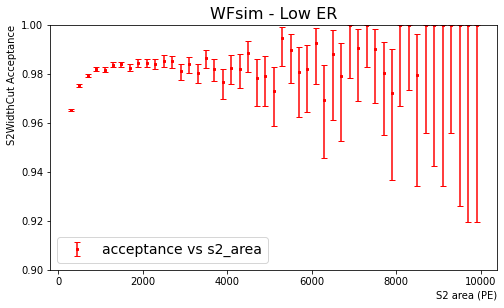

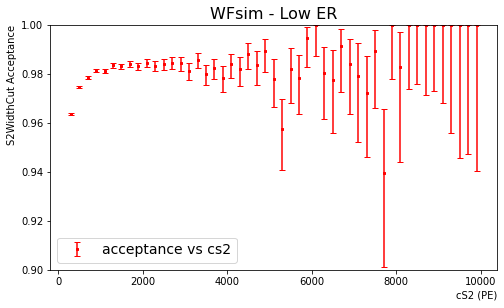

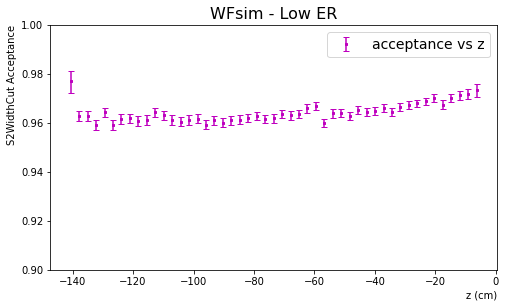

In [31]:
#wcu.plot_r2z_xy(ev_sim, 'WFsim')
accSim_low_er = wcu.get_acceptance(ev_sim, cut_mask_sim_low_er,sim=1, title='WFsim - Low ER', alim=(0.9,1))

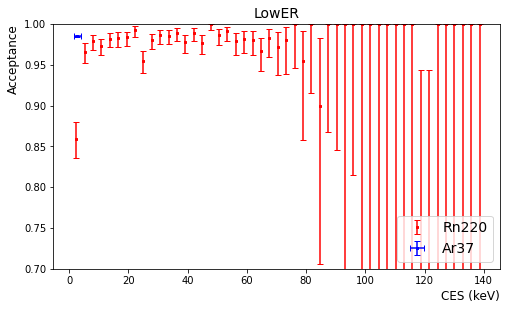

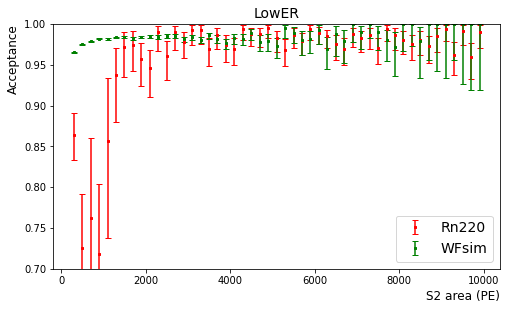

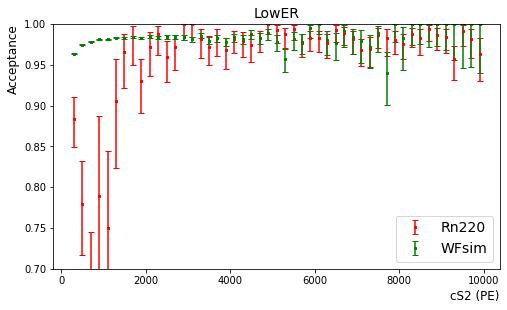

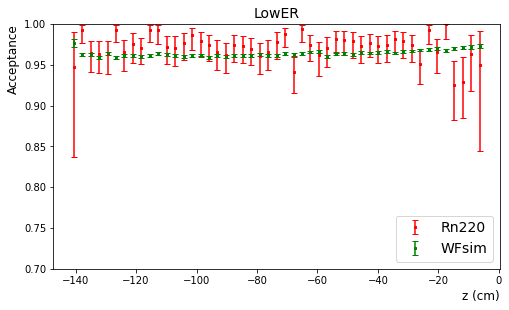

In [32]:
wcu.plot_acceptance(accRn_low_er, accSim_low_er,acc_ar=accAr_low_er, alim=(0.7,1),title='LowER', info='Rn220',save=1)

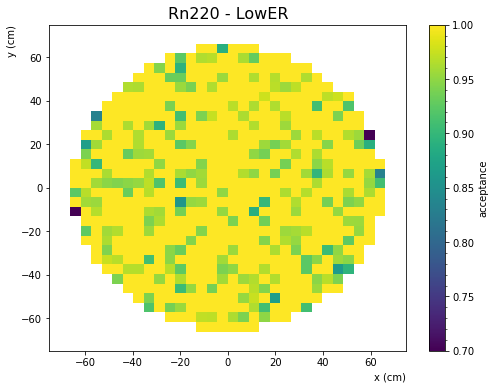

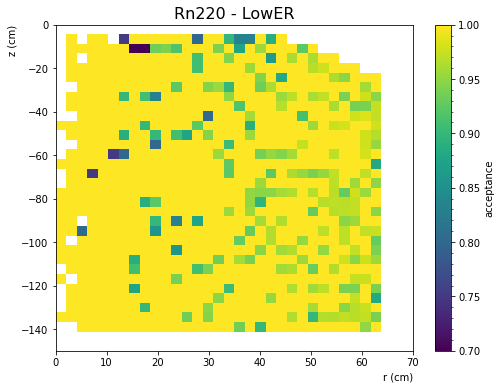

In [35]:
wcu.get_acceptance_2d(evRn_l, evRn_l['cut_s2_width_wire_modeled_low_er'], title='Rn220 - LowER', bins = 35,name='rn220_low_er_')

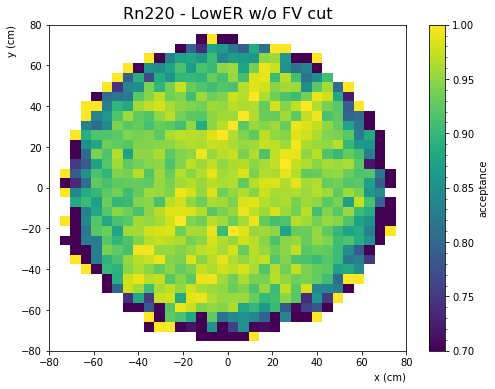

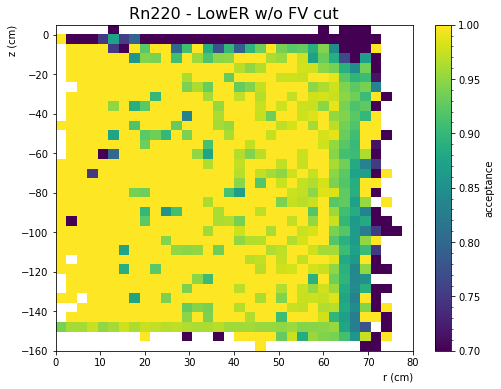

In [36]:
evRn_ = evRn0[wcu.all_cuts(evRn0,low_er=1,FV=0)]
wcu.get_acceptance_2d(evRn_, evRn_['cut_s2_width_wire_modeled_low_er'], title='Rn220 - LowER w/o FV cut', bins = 35,
                      xlim=80,rlim=(0,80),zlim=(-160,5),name='rn220_low_er_nofv_')